In [29]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
import os
from dotmap import DotMap
from tqdm import tqdm
from PIL import Image, ImageOps
from torchvision import transforms

from src.datasets.cub200 import TestDataset
from src.models import configure_model
from src.evaluate.ranking import compute_rank
from src.evaluate.evaluate import evaluate
from src.evaluate.utils import get_pos_idx, get_pos_idx_place_recognition, remove_duplicates

In [2]:
args = {"dataset": "cub200", 
        "resume": "lightning_logs/cub200/deterministic/1/checkpoints/best.ckpt",
        "data_dir": "/home/warburg/data",        
        "arch": "resnet50", 
        "pool": "gem",
        "whitening": True, 
        "pretrained": True, 
        "dropout_rate": 0.0, 
        "latent_dim": 512}
args = DotMap(args)

In [11]:
def rename_keys(statedict):

    new_dict = {k.replace("model.", ""): statedict[k] for k in statedict.keys()}
    return new_dict


model = configure_model(args)
statedict = torch.load(args.resume, map_location="cpu")["state_dict"]
statedict = rename_keys(statedict)
model.load_state_dict(statedict)
model.eval()
model = model.cuda()

>> Using pre-trained model 'resnet50'


/home/warburg/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/warburg/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
data = TestDataset(args.data_dir)
dataloader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=False)

In [13]:
outputs = []
for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    
    if args.dataset == "msls":
        x, index, utm = batch
    else:
        x, target = batch

    x = x.cuda()
    with torch.no_grad():
        output = model(x)

    # ensure that features are l2 normalized
    z_mu = output["z_mu"]
    z_mu = z_mu / torch.norm(z_mu, dim=-1, keepdim=True)

    o = {"z_mu": z_mu.cpu()}

    if args.dataset == "msls":
        o["index"] = torch.stack(index).cpu()
        o["utm"] = utm.cpu()
    else:
        o["label"] = target.cpu()

    if "z_sigma" in output:
        o["z_sigma"] = output["z_sigma"].cpu()

    if "z_samples" in output:
        z_samples = output["z_samples"]
        # ensure that samples are also l2 normalize
        z_samples = z_samples / torch.norm(z_samples, dim=-1, keepdim=True)
        o["z_samples"] = z_samples.cpu()
    
    outputs.append(o)

100%|██████████| 93/93 [01:05<00:00,  1.42it/s]


In [14]:
def format_outputs(outputs, place_rec=False):

        z_mu = torch.cat([o["z_mu"] for o in outputs])
        if not place_rec:
            targets = torch.cat([o["label"] for o in outputs])
            pidxs = get_pos_idx(targets)
            z_muQ = z_mu
            z_muDb = None
        else:

            index = torch.cat([o["index"] for o in outputs], dim=1)
            utm = torch.cat([o["utm"] for o in outputs])

            queries = index[1, :] == -1
            database = ~queries

            z_muQ = z_mu[queries]
            z_muDb = z_mu[database]
            utmQ = utm[queries]
            utmDb = utm[database]
            idxQ = index[0, :][queries]
            idxDb = index[1, :][database]
            z_muQ, z_muDb, utmQ, utmDb = remove_duplicates(
                z_muQ, z_muDb, utmQ, utmDb, idxQ, idxDb
            )

            pidxs = get_pos_idx_place_recognition(utmQ, utmDb, 25)

        if z_muDb is not None and len(z_muDb) == 0:
            return

        o = {"z_muQ": z_muQ, "z_muDb": z_muDb, "pidxs": pidxs}
        if not place_rec:
            o["targets"] = targets

        if "z_sigma" in outputs[0]:
            z_sigma = torch.cat([o["z_sigma"] for o in outputs])
            if z_muDb is None:
                # merge dicts
                o = {**o, **{"z_sigmaQ": z_sigma, "z_sigmaDb": None}}

        if "z_samples" in outputs[0]:
            z_samples = torch.cat([o["z_samples"] for o in outputs])
            if z_muDb is None:
                # merge dicts
                o = {**o, **{"z_samplesQ": z_samples, "z_samplesDb": None}}

        return o

In [15]:
outputs = format_outputs(outputs, place_rec=args.datasets == "msls")
ranks = compute_rank(outputs["z_muQ"], ref_embed=outputs["z_muDb"])
evaluate(ranks, outputs["pidxs"])

{'map': [0.4871078100382624, 0.4243669683718637, 0.3557752808411572],
 'recall': [0.611580013504389,
  0.8418298446995274,
  0.9027683997299122,
  0.9453072248480756]}

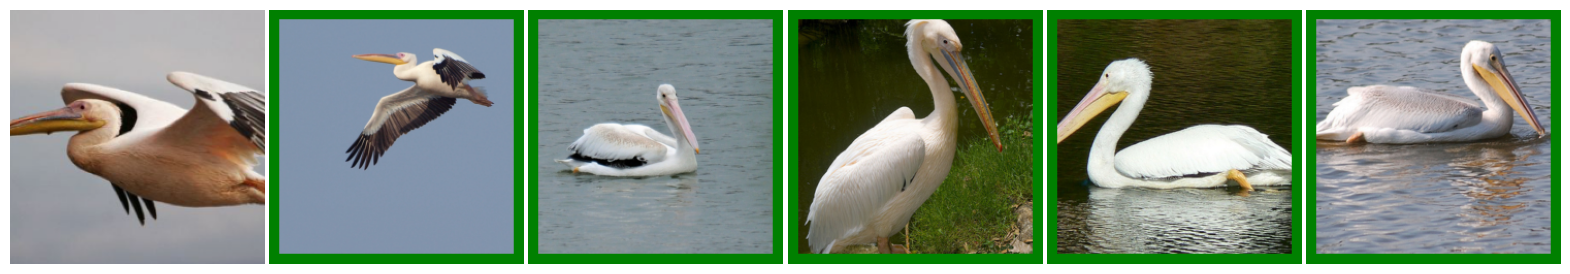

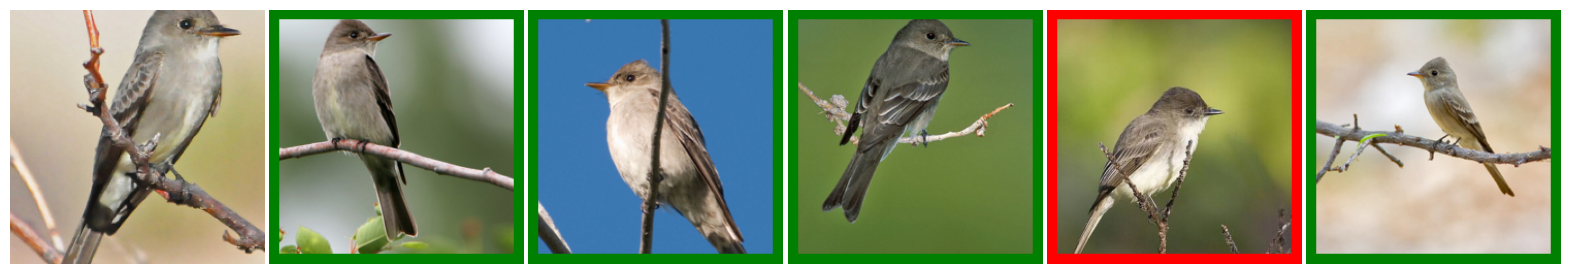

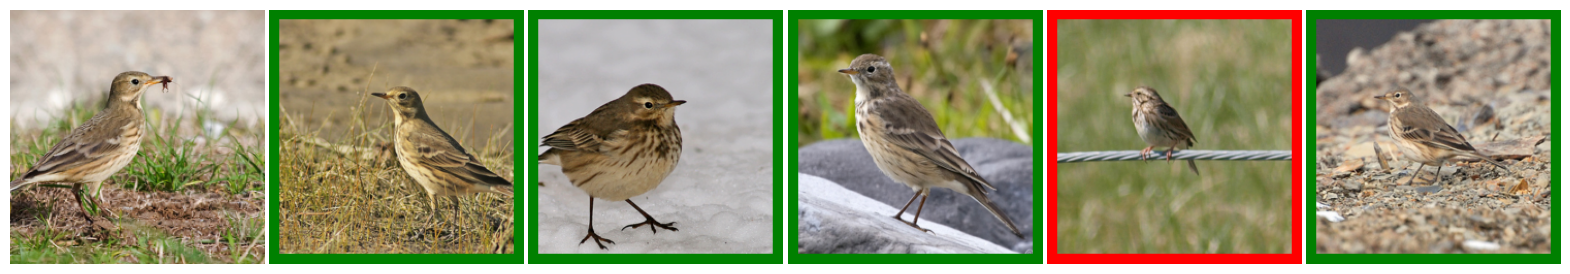

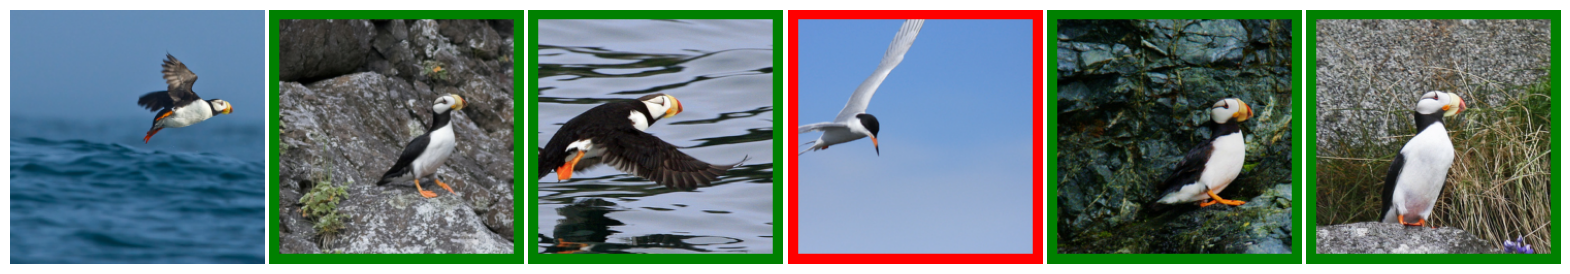

In [44]:
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
)
transform = transforms.ToPILImage()

for q_id in [0,100,200,300]:

    fig, ax = plt.subplots(1, 6, figsize=(20, 20))

    im, q_label = data.__getitem__(q_id)
    im = inv_normalize(im)
    ax[0].imshow(im.permute(1, 2, 0))
    ax[0].axis("off")

    for i, n_idx in enumerate(ranks[q_id, :5]):
        im, n_label = data.__getitem__(n_idx)
        im = inv_normalize(im)
        #im = im.permute(1, 2, 0)
        im = transform(im)

        
        if q_label == n_label:
            # color border green
            im = ImageOps.expand(im,border=10,fill='green')
        else:
            # color border red
            im = ImageOps.expand(im,border=10,fill='red')

        ax[i+1].imshow(im)
        ax[i+1].axis("off")
        
    plt.subplots_adjust(wspace=0.02, hspace=0)
    plt.show()